In [1]:
!pip install tensorflow
!pip install tensorflow_hub
!pip install -q -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

  Obtaining dependency information for tf-models-official==2.13.* from https://files.pythonhosted.org/packages/d8/c3/4511e49412492966f4e6e0a20b41ae66d027e5a76e8c2b436b591ecc4273/tf_models_official-2.13.2-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 1.8 MB/s eta 0:00:00
  Obtaining dependency information for immutabledict from https://files.pythonhosted.org/packages/77/d8/69b89c358609ef1853d860bcf59472abe65e2c434767e6e91c57e12e5c23/immutabledict-4.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for sacrebleu from https://files.pythonhosted.org/packages/0a/a6/2ac47e71e526bbcd97ea08f20d9ef7d3852e2594ec7b2d55f5d2bbfd7aae/sacrebleu-2.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from official.nlp import optimization
import os
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dataset = pd.read_csv("/kaggle/input/sn-dataset/dataset_sn.csv")
dataset = dataset.drop('type', axis=1)

# Cetak dataset pelatihan
print("List Dataset:")
print(dataset)

List Dataset:
    label                                                 SN
0       S  Saya menyukai hal-hal yang konkret dan praktis...
1       S  Saya lebih memilih berfokus pada fakta dan log...
2       S  Saya menghargai kejujuran dan konsistensi, dan...
3       S  Saya lebih nyaman ketika memiliki jadwal yang ...
4       S  Saya suka mengamati hal-hal yang ada di sekita...
..    ...                                                ...
395     N  Saya lebih terbuka terhadap konsep abstrak, se...
396     N  Saya merasa terkoneksi dengan ide-ide yang bel...
397     N  Keputusan saya cenderung dipengaruhi oleh intu...
398     N  Tanpa perlu dipandu oleh petunjuk yang rinci, ...
399     N  Kesanggupannya untuk membaca ekspresi wajah da...

[400 rows x 2 columns]


In [4]:
df = pd.DataFrame(dataset)
df['SN'] = df['SN'].str.strip()

# Membagi dataset berdasarkan kelompok
grouped = df.groupby('label')

# Inisialisasi DataFrame train dan valid
df_train = pd.DataFrame()
df_valid = pd.DataFrame()

# Memproses setiap kelompok
for name, group in grouped:
    # Menentukan jumlah data untuk validasi
    valid_size = int(len(group) * 0.2)

    # Memilih data untuk validasi
    valid_data = group.sample(n=valid_size, random_state=42)

    # Memilih data untuk train
    train_data = group.drop(valid_data.index)

    # Menggabungkan hasil pemisahan ke dalam DataFrame train dan valid
    df_train = pd.concat([df_train, train_data])
    df_valid = pd.concat([df_valid, valid_data])

#acak
df_train = df_train.sample(frac=1, random_state=42)
df_valid= df_valid.sample(frac=1, random_state=42)

# Cetak hasil
# print("Data Train:")
# print(df_train)
# print("\nData Valid:")
# print(df_valid)

In [5]:
train_data = df_train
valid_data = df_valid
target_label = 'S' #label 1 Ekstrovert #label 1 Sensing #label 1 feeling #label 1 perceiving
label_train = (train_data['label'].str[0] == target_label).astype(int).to_numpy()
label_valid = (valid_data['label'].str[0] == target_label).astype(int).to_numpy()

In [6]:
x_train = train_data['SN'].to_numpy() #isi sesuai kolom dataset
x_valid = valid_data['SN'].to_numpy()
# print(x_train.shape,x_valid.shape)
# # print(label_train)
# # print(x_train)

In [7]:
encoder_url = '/kaggle/input/bert/tensorflow2/multi-cased-l-12-h-768-a-12/4'
preprocess_url = "/kaggle/input/bert/tensorflow2/multi-cased-preprocess/3"
embedding_model1 = hub.KerasLayer(encoder_url, trainable=True)
preprocess_model1 = hub.KerasLayer(preprocess_url)

In [8]:
def build_classifier_model():
    text_input1 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text1')
    
    # Gunakan lapisan pre-processing terpisah untuk setiap input
    preprocessing_layer1 = hub.KerasLayer(preprocess_model1, name='preprocessing1')
    encoder_inputs1 = preprocessing_layer1(text_input1)
    encoder1 = hub.KerasLayer(embedding_model1, name='BERT_encoder_1', trainable=True)
    outputs1 = encoder1(encoder_inputs1)['pooled_output']
    outputs1 = tf.keras.layers.Dropout(0.5 , name="dropout")(outputs1)
    label1 = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier1')(outputs1)

    return tf.keras.Model(inputs=[text_input1], outputs=[label1])


In [9]:
model = build_classifier_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text1 (InputLayer)          [(None,)]                    0         []                            
                                                                                                  
 preprocessing1 (KerasLayer  {'input_type_ids': (None,    0         ['text1[0][0]']               
 )                           128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

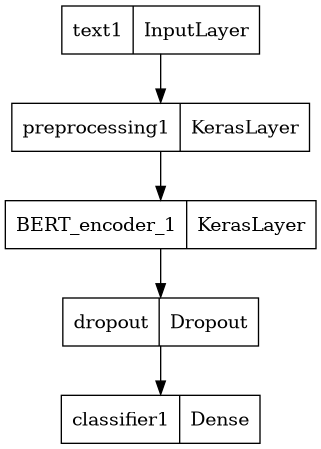

In [10]:
tf.keras.utils.plot_model(model)

In [11]:
epochs = 5
steps_per_epoch = 16
batch_size = 2
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)

In [12]:
!pip install -q tf-models-official

In [13]:
# model.compile(optimizer=optimizer,
#                          loss=loss,
#                          metrics=metrics)
# model.load_weights("/content/drive/MyDrive/model_checkpoint_best.h5")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss=tf.keras.losses.BinaryCrossentropy(),  # Fungsi kerugian untuk klasifikasi biner
              metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Path untuk menyimpan checkpoint pada setiap epoch
checkpoint_path_epoch = "/content/drive/MyDrive/model_checkpoint_epoch.h5"

# Path untuk menyimpan checkpoint model terbaik
checkpoint_path_best = "/content/drive/MyDrive/model_checkpoint_best.h5"

# Callback untuk menyimpan checkpoint pada setiap epoch
checkpoint_callback_epoch = ModelCheckpoint(
    filepath=checkpoint_path_epoch,
    save_weights_only=True,
    save_best_only=False,  # Set ke False agar menyimpan pada setiap epoch
    verbose=1
)

# Callback untuk menyimpan checkpoint model terbaik
checkpoint_callback_best = ModelCheckpoint(
    filepath=checkpoint_path_best,
    save_weights_only=True,
    save_best_only=True,  # Set ke True agar hanya menyimpan model terbaik
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [15]:
# untuk lanjut
model.fit(
    x=x_train, y=label_train,
    epochs=20,
    validation_data=(x_valid, label_valid),batch_size=batch_size,
)

Epoch 1/20
160/160 [==============================] - 66s 144ms/step - loss: 0.7231 - accuracy: 0.5188 - val_loss: 0.6962 - val_accuracy: 0.4500
Epoch 2/20
160/160 [==============================] - 13s 80ms/step - loss: 0.7003 - accuracy: 0.5250 - val_loss: 0.6804 - val_accuracy: 0.5625
Epoch 3/20
160/160 [==============================] - 12s 75ms/step - loss: 0.7030 - accuracy: 0.5281 - val_loss: 0.6700 - val_accuracy: 0.5875
Epoch 4/20
160/160 [==============================] - 11s 70ms/step - loss: 0.6773 - accuracy: 0.6031 - val_loss: 0.6519 - val_accuracy: 0.6625
Epoch 5/20
160/160 [==============================] - 11s 68ms/step - loss: 0.6352 - accuracy: 0.6406 - val_loss: 0.6150 - val_accuracy: 0.6875
Epoch 6/20
160/160 [==============================] - 11s 68ms/step - loss: 0.6028 - accuracy: 0.6844 - val_loss: 0.5491 - val_accuracy: 0.8000
Epoch 7/20
160/160 [==============================] - 11s 69ms/step - loss: 0.5407 - accuracy: 0.7531 - val_loss: 0.4955 - val_accuracy

In [21]:
model.predict(["cenderung peka terhadap lingkungan sekitarnya, selalu memperhatikan detail-detail kecil, dan benci mengandalkan fakta-fakta yang konkret dalam pengambilan keputusan"])

1/1 [==============================] - 0s 39ms/step


array([[0.99485755]], dtype=float32)

In [24]:
model.save("sn_model.h5", include_optimizer=False)

NotImplementedError: Can only generate a valid config for `hub.KerasLayer(handle, ...)`that uses a string `handle`.

Got `type(handle)`: <class 'tensorflow_hub.keras_layer.KerasLayer'>

In [25]:
# Mendapatkan daftar perangkat yang tersedia (CPU dan GPU)
devices = tf.config.list_physical_devices()

if len(devices) == 0:
    print("Tidak ada perangkat fisik yang ditemukan.")
else:
    print("Perangkat yang tersedia:")
    for device in devices:
        print(f"- {device.name} ({device.device_type})")

Perangkat yang tersedia:
- /physical_device:CPU:0 (CPU)
- /physical_device:GPU:0 (GPU)


In [26]:
print(model.predict(["sayap pergi sangat mudah temukan berhubungan setiap enneagram infj langka mustahil tidak mungkin semuanya mungkin tergantung naikkan cuure dll menang temukan banyak enneagram individualis di korea utara contoh mungkin kamp konsentrasi mh tebak akan membantu akan menemukan dosa mematikan lihat masalah lol iri sangat jelas tidak puas salah satu favorit katakan agak suka menyalin mekanisme seperti tidak ada hal semuanya akan baik-baik saja mungkin berpengaruh dengan baik semoga memperbaiki kerakusan di bawah kendali kecuali menggoda rumah coklat makan semuanya suatu hari gulma merokok tidak ada yang meninggalkan orang yang terlalu marah berarti kencing lelucon inti mempengaruhi banyak prolly w bermain dengan baik seseorang sesuatu yang terbelakang cara perlahan-lahan membuat gila seperti tahu seperti hei mengemudi kayu tengah tidak ada tempat duduk biarkan mengambil roda mobil duduk menang dapat mengemudi lagi hei paling tidak bisa duduk hahahahah ieriozuepoanhceiphfiozejfijrioe berhenti contoh buruk cukup mudah-mudahan memperbaiki fokus pikiran yang sadar akan sangat membantu dengan baik mungkin membutuhkan waktu pada akhirnya menjadi jelas kirim sesuatu mungkin perlu perubahan tahu partikal diskrit berpikir sebagian besar berpikir cara terhitung banyaknya bayangkan paling tidak mendekati sesuatu yang diskrit bahkan seperti fungsi tidak pernah cukup konvergen masalah fungsi kontinu topps mengurutkan basis deteksi emulasi menggunakan perangkat lunak tertentu menggunakan tujuan perangkat lunak bahkan meniru akan memicu perma larangan membeli paket skema baru-baru ini berharap satu opsi izinkan giliran animasi ingin mengenai paket kartu tambahkan stok perlu melihat paket terbuka pasti ingin melihat sumber daya jelek hit ringan terjadi kartu pertama oleh karena itu tutup waktu paket berhenti buka paket paling tidak akan cepat secara teoritis topps dapat memperkenalkan opsi pembelian mui akan sangat buruk aplikasi setidaknya tombol pembelian paket manual lambat pembeli besar pembeli kecil dapatkan paket populer jika tidak, paus dapat sepenuhnya membeli kartu satu pembelian tahu benar berani orang berpikir percaya hal mengatakan dunia pukulan tongkat mengapung selamanya ruang membekukan bola mati lemas mampu membuat kesepakatan kesengsaraan dua secara profesional mengakhiri kebencian cocok stereotip buruk keras suka memerintah kaku tak kenal ampun menurunkan semangat menjengkelkan satu mitra bisnis bertarung dengan keras secara agresif menunggu satu sama lain departemen pekerjaan yang berbeda mempengaruhi pekerjaan orang menjengkelkan yang menyedihkan membuat semua orang di sekitar menderita harapan bertemu dengan contoh yang baik sosiopat masa depan imo mengatakan dengan tepat satu akan mengatakan edit oh terima kasih Tuhan semua orang mendapatkan keramahan yang rendah jujur ?de?????de????menang mudah intj entj fungsi urutan yang berbeda intjs seperti banyak introvert sering memimpin fungsi tambahan situasi sosial perbedaan besar entjs kebutuhan tinggi menyelesaikan hal intjs kebutuhan tinggi secara akurat memahami intjs datang menggigit lalai ni biarkan kepala hidup gunakan te secara proaktif menjaga lebih memilih dukungan lingkungan ni mampu menjaga tatanan lingkungan ideal dengan benar mengarahkan energi ke dalam entj gunakan ni melayani te gunakan refleksi prediksi memesan tujuan satu cara mungkin membedakan reaksi gangguan lingkungan intj menjengkelkan seperti perbaikan hebat mendapatkan kembali hal yang sangat peduli entj oportunistik berpikir peluang besar mengatur ulang cara pasti enfps cinta istjs baik gender teman enfps kreativitas semangat hidup menemukan sangat menarik sensitivitas bebas semangat keseimbangan dingin kekakuan tambahan fi tersier te temukan di antara orang-orang yang sangat memahami nilai pandangan dunia bahkan setuju meskipun istjs berbagi fungsi sering menemukan tangkapan membatasi si konotasi teman monster monster berpikir pengungkapan penuh entj bisnis pesanan biasa yaitu menginjak-injak menggambarkan monster seperti romantisisasi yang tidak perlu sama sekali sarung pedang dll melayani gangguan mungkin mengambil fakta berhenti memberi tahu op monster"]))

1/1 [==============================] - 0s 43ms/step
[[0.9780377]]
